In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [14]:
# Load data
transactions_df = pd.read_excel('transactions.xlsx', parse_dates=['Date'])
transactions_df.head()

,Date,Description,Amount,Transaction Type,Category,Account Name,Month
0,2018-01-01,Amazon,11.11,debit,Shopping,Platinum Card,2018-01
1,2018-01-02,Mortgage Payment,1247.44,debit,Mortgage & Rent,Checking,2018-01
2,2018-01-02,Thai Restaurant,24.22,debit,Restaurants,Silver Card,2018-01
3,2018-01-03,Credit Card Payment,2298.09,credit,Credit Card Payment,Platinum Card,2018-01
4,2018-01-04,Netflix,11.76,debit,Movies & Dvds,Platinum Card,2018-01


In [15]:
transactions_df.shape

(806, 7)

In [16]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806 entries, 0 to 805
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              806 non-null    datetime64[ns]
 1   Description       806 non-null    object        
 2   Amount            806 non-null    float64       
 3   Transaction Type  806 non-null    object        
 4   Category          806 non-null    object        
 5   Account Name      806 non-null    object        
 6   Month             806 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 44.2+ KB


# Define category

In [17]:
# Define new category groups
category_groups = {
    'groceries': ['Groceries'],
    'shopping': ['Amazon', 'Shopping', 'Electronics & Software'],
    'utilities': ['Utilities', 'Gas Company', 'Power Company', 'Internet', 'Mobile Phone','Auto Insurance'],
    'rent': ['Mortgage & Rent'],
    #'income': ['Paycheck'],
    'dining': ['Restaurants', 'Fast Food', 'Coffee Shops', 'Alcohol & Bars'],
    'entertainment': ['Movies & Dvds', 'Music', 'Television', 'Netflix', 'Spotify']
}

# Map new grouped categories back to categories
def map_to_group(category):
    for group, subcats in category_groups.items():
        if category in subcats:
            return group
    return 'other'

transactions_df['Category_Group'] = transactions_df['Category'].apply(map_to_group)


# Groupe total spend 

In [19]:
# Group total spend per day
transactions_df['Date'] = pd.to_datetime(transactions_df['Date'])

# Add date-based features
transactions_df['Date'] = pd.to_datetime(transactions_df['Date'])
transactions_df['month'] = transactions_df['Date'].dt.month
transactions_df['year'] = transactions_df['Date'].dt.year
transactions_df['quarter'] = transactions_df['Date'].dt.quarter
transactions_df['day_of_week'] = transactions_df['Date'].dt.dayofweek
transactions_df['is_weekend'] = transactions_df['day_of_week'].isin([5, 6]).astype(int)
transactions_df['day'] = transactions_df['Date'].dt.day

# Group total spend per month per category
daily_amounts = transactions_df.groupby(['month', 'year', 'Category_Group'])['Amount'].sum().reset_index()
daily_amounts = daily_amounts[daily_amounts['Category_Group'] != 'other']

# Add a date_key for sorting and lag computation
daily_amounts['date_key'] = pd.to_datetime(daily_amounts['year'].astype(str) + '-' + daily_amounts['month'].astype(str) + '-01')
daily_amounts = daily_amounts.sort_values(['Category_Group', 'date_key'])

# Add lag feature (previous month's amount per category)
daily_amounts['prev_month_amount'] = daily_amounts.groupby('Category_Group')['Amount'].shift(1)
daily_amounts['prev_month_amount'] = daily_amounts['prev_month_amount'].fillna(0)

# One-hot encode Category_Group
daily_amounts = pd.concat([daily_amounts, pd.get_dummies(daily_amounts['Category_Group'])], axis=1)

# Log-transform the lag feature (to stabilize variance)
daily_amounts['log_prev_month'] = np.log1p(daily_amounts['prev_month_amount'])

# Final dataset for model
daily_amounts_new = daily_amounts.drop(['Category_Group', 'date_key', 'prev_month_amount'], axis=1)


In [20]:
daily_amounts_new.tail()

,month,year,Amount,dining,entertainment,groceries,rent,shopping,utilities,log_prev_month
69,5,2019,340.0,False,False,False,False,False,True,5.831882
83,6,2019,340.0,False,False,False,False,False,True,5.831882
97,7,2019,340.0,False,False,False,False,False,True,5.831882
111,8,2019,340.0,False,False,False,False,False,True,5.831882
125,9,2019,340.0,False,False,False,False,False,True,5.831882


# Features and Target

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

# Features and target

X = daily_amounts_new.drop(['Amount'],axis=1)
y = np.log(daily_amounts_new['Amount'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Linear Regression
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R²): {r2:.4f}')

# Inverse transform predictions and actuals (back to dollar scale)
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred_lr)

# Calculate RMSE in dollars
rmse_dollars = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
print(f'Root Mean Squared Error (in $): ${rmse_dollars:.2f}')

Mean Squared Error (MSE): 0.2660
R-squared (R²): 0.8323
Root Mean Squared Error (in $): $72.10


In [22]:
X_train.columns

Index(['month', 'year', 'dining', 'entertainment', 'groceries', 'rent',
       'shopping', 'utilities', 'log_prev_month'],
      dtype='object')

# Visualization

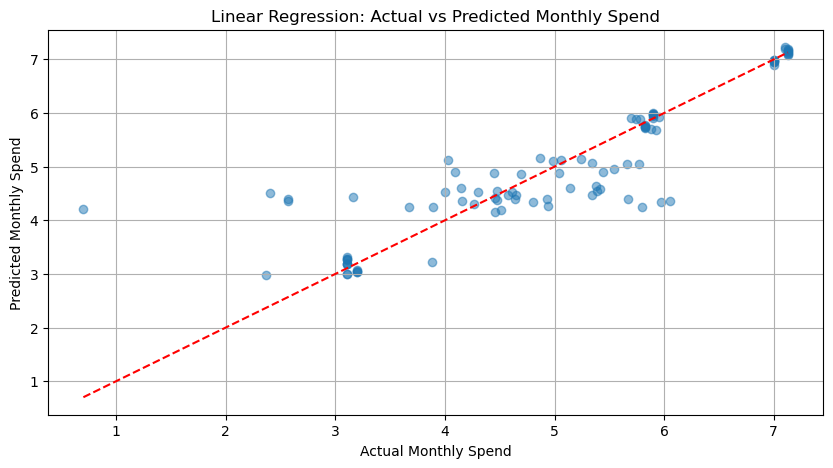

In [23]:
import matplotlib.pyplot as plt

# Predict values from linear model
y_pred = lr.predict(X_train)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.scatter(y_train, y_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # Ideal line
plt.xlabel('Actual Monthly Spend')
plt.ylabel('Predicted Monthly Spend')
plt.title('Linear Regression: Actual vs Predicted Monthly Spend')
plt.grid(True)
plt.show()

   Year  Month       Category  Predicted_Amount
0  2019     10         dining        412.258548
0  2019     10  entertainment        170.315238
0  2019     10      groceries         27.046816
0  2019     10           rent        103.374327
0  2019     10       shopping         89.215874
0  2019     10      utilities       1395.744690
0  2019     11         dining        417.884543
0  2019     11  entertainment        172.639489
0  2019     11      groceries         27.415917
0  2019     11           rent        104.785051
0  2019     11       shopping         90.433382
0  2019     11      utilities       1414.792086
0  2019     12         dining        423.587313
0  2019     12  entertainment        174.995459
0  2019     12      groceries         27.790056
0  2019     12           rent        106.215028
0  2019     12       shopping         91.667505
0  2019     12      utilities       1434.099416


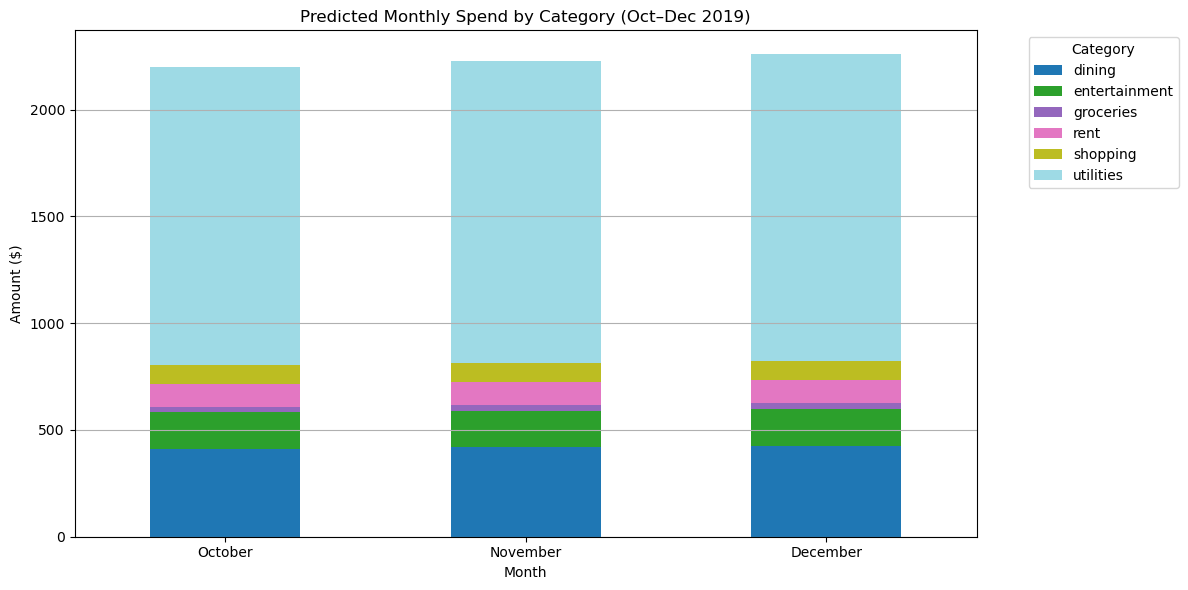

In [25]:
# Predict for remaining 2019 months (Oct, Nov, Dec)
future_months = [10, 11, 12]
predictions_df = pd.DataFrame()

category_groups_names = [i for i in category_groups.keys()]
for month in future_months:
    for idx, name in enumerate(category_groups_names):
        category_dummies = np.zeros(len(category_groups_names))
        category_dummies[idx] += 1
        # Use avg lag value from training or compute category-specific last available value
        avg_lag = X_train['log_prev_month'].mean()
        X_predict = np.append([month, 2019, avg_lag], category_dummies)
        X_predict = pd.DataFrame(X_predict).T
        X_predict.columns = X.columns
        pred_amount = np.exp(lr.predict(X_predict))[0]

        predictions_df = pd.concat([
            predictions_df,
            pd.DataFrame({
                'Year': [2019],
                'Month': [month],
                'Category': [name],
                'Predicted_Amount': [pred_amount]
            })
        ])

# Display prediction table
print(predictions_df.sort_values(['Month', 'Category']))

# Pivot for visualization
pivot_pred = predictions_df.pivot(index='Month', columns='Category', values='Predicted_Amount')

# Plot monthly category spend (stacked bar)
pivot_pred.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Predicted Monthly Spend by Category (Oct–Dec 2019)')
plt.ylabel('Amount ($)')
plt.xlabel('Month')
plt.xticks([0, 1, 2], ['October', 'November', 'December'], rotation=0)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Define Income dictionary

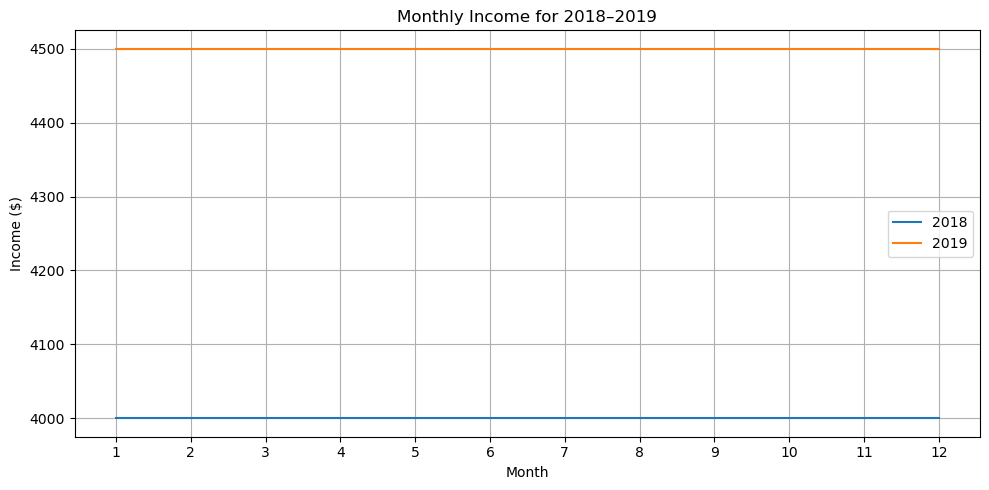

In [26]:
import matplotlib.pyplot as plt

# Define income dictionary for 2018–2019
bi_paycheck = {2018: 2000, 2019: 2250}

# Create monthly income DataFrame
income_data = []
for year in [2018, 2019]:
    for month in range(1, 13):
        income = bi_paycheck[year] * 2
        income_data.append({'Year': year, 'Month': month, 'Income': income})

income_df = pd.DataFrame(income_data)

# Plot income per month
plt.figure(figsize=(10, 5))
for year in [2018, 2019]:
    monthly = income_df[income_df['Year'] == year]
    plt.plot(monthly['Month'], monthly['Income'], label=f'{year}')

plt.title('Monthly Income for 2018–2019')
plt.xlabel('Month')
plt.ylabel('Income ($)')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# Ensure proper datetime format
transactions_df['Date'] = pd.to_datetime(transactions_df['Date'])

# Group historical data by month/year/category
transactions_df['month'] = transactions_df['Date'].dt.month
transactions_df['year'] = transactions_df['Date'].dt.year

monthly_hist = transactions_df.groupby(['year', 'month', 'Category_Group'])['Amount'].sum().reset_index()
monthly_hist = monthly_hist[monthly_hist['Category_Group'] != 'other']
monthly_hist['Date'] = pd.to_datetime(dict(year=monthly_hist['year'], month=monthly_hist['month'], day=1))
monthly_hist = monthly_hist.rename(columns={'Category_Group': 'Category'})

# Keep only 2018–2019 historical data for matching
monthly_hist = monthly_hist[(monthly_hist['year'] == 2018) | (monthly_hist['year'] == 2019)]

In [31]:
# Prepare predicted data for plotting
pred_plot_df = predictions_df.copy()
pred_plot_df['Date'] = pd.to_datetime(dict(year=pred_plot_df['Year'], month=pred_plot_df['Month'], day=1))

# Match column names
pred_plot_df = pred_plot_df[['Date', 'Category', 'Predicted_Amount']]
pred_plot_df = pred_plot_df.rename(columns={'Predicted_Amount': 'Amount'})
pred_plot_df['Type'] = 'Predicted'
monthly_hist['Type'] = 'Actual'

# Match columns and concat
combined_df = pd.concat([
    monthly_hist[['Date', 'Category', 'Amount', 'Type']],
    pred_plot_df[['Date', 'Category', 'Amount', 'Type']]
])

# Income Data 

In [32]:
import plotly.graph_objs as go
import plotly.offline as pyo

# ----------- Income Data (2018–2019) ----------
income_data = []
bi_paycheck = {2018: 2000, 2019: 2250}

for year in [2018, 2019]:
    for month in range(1, 13):
        income_data.append({
            'Year': year,
            'Month': month,
            'Income': bi_paycheck[year] * 2
        })

income_df = pd.DataFrame(income_data)

# Create traces for income
trace_income_2018 = go.Scatter(
    x=income_df[income_df['Year'] == 2018]['Month'],
    y=income_df[income_df['Year'] == 2018]['Income'],
    mode='lines+markers',
    name='Income 2018'
)

trace_income_2019 = go.Scatter(
    x=income_df[income_df['Year'] == 2019]['Month'],
    y=income_df[income_df['Year'] == 2019]['Income'],
    mode='lines+markers',
    name='Income 2019'
)

fig_income = go.Figure(data=[trace_income_2018, trace_income_2019])
fig_income.update_layout(title='Monthly Income (2018–2019)',
                         xaxis_title='Month',
                         yaxis_title='Income ($)',
                         template='plotly_white')

# Save to HTML div
income_div = pyo.plot(fig_income, include_plotlyjs=False, output_type='div')


# ----------- Predicted Expenses for Oct–Dec 2019 ----------
# Use predictions_df from earlier prediction step

pivot_pred = predictions_df.pivot(index='Month', columns='Category', values='Predicted_Amount')
bar_traces = []

for category in pivot_pred.columns:
    bar_traces.append(
        go.Bar(
            x=['October', 'November', 'December'],
            y=pivot_pred[category],
            name=category
        )
    )

fig_expense = go.Figure(data=bar_traces)
fig_expense.update_layout(
    barmode='stack',
    title='Predicted Expenses by Category (Oct–Dec 2019)',
    xaxis_title='Month',
    yaxis_title='Expense ($)',
    template='plotly_white'
)

# Save to HTML div
expense_div = pyo.plot(fig_expense, include_plotlyjs=False, output_type='div')

# --- Generate Historical vs Predicted Expense Line Chart ---

category_traces = []
for category in combined_df['Category'].unique():
    df_actual = combined_df[(combined_df['Category'] == category) & (combined_df['Type'] == 'Actual')]
    df_pred = combined_df[(combined_df['Category'] == category) & (combined_df['Type'] == 'Predicted')]

    category_traces.append(go.Scatter(
        x=df_actual['Date'],
        y=df_actual['Amount'],
        mode='lines+markers',
        name=f'{category} (Actual)'
    ))
    category_traces.append(go.Scatter(
        x=df_pred['Date'],
        y=df_pred['Amount'],
        mode='lines+markers',
        name=f'{category} (Predicted)',
        line=dict(dash='dash')
    ))

fig_hist_pred = go.Figure(data=category_traces)
fig_hist_pred.update_layout(
    title='Historical vs Predicted Expenses by Category (2018–2019)',
    xaxis_title='Date',
    yaxis_title='Amount ($)',
    template='plotly_white'
)

# Save to HTML div
hist_pred_div = pyo.plot(fig_hist_pred, include_plotlyjs=False, output_type='div')

# Html Template

In [33]:
html_template = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Financial Analysis Dashboard</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 40px;
        }}
        h2 {{
            color: #2c3e50;
        }}
        .chart-container {{
            margin-bottom: 60px;
        }}
    </style>
</head>
<body>
    <h1>Financial Dashboard: Income & Expense Forecast</h1>

    <div class="chart-container">
        <h2>Monthly Income (2018–2019)</h2>
        {income_div}
    </div>

    <div class="chart-container">
        <h2>Predicted Expenses by Category (Oct–Dec 2019)</h2>
        {expense_div}
    </div>

    <div class="chart-container">
        <h2>Historical vs Predicted Expenses by Category</h2>
        {hist_pred_div}
    </div>
</body>
</html>
"""

with open("financial_dashboard.html", "w") as f:
    f.write(html_template)

# Prediction on test

In [14]:
from sklearn.metrics import mean_squared_error

# Make predictions on test set
y_pred_test = lr.predict(X_test)

# Calculate MSE (in log space)
mse_log = mean_squared_error(y_test, y_pred_test)
print(f"MSE on log scale: {mse_log:.4f}")

# Convert back to original dollar scale for interpretation
y_test_actual = np.exp(y_test)
y_pred_actual = np.exp(y_pred_test)
mse_actual = mean_squared_error(y_test_actual, y_pred_actual)
print(f"MSE in actual dollars: {mse_actual:.2f}")

# Calculate RMSE (root mean squared error) for more interpretable units
rmse_actual = np.sqrt(mse_actual)
print(f"Root MSE in dollars: {rmse_actual:.2f}")

MSE on log scale: 0.8360
MSE in actual dollars: 7261.40
Root MSE in dollars: 85.21


In [15]:
avg_monthly_spend = np.exp(y_train).mean()
print(f"Average monthly spending: ${avg_monthly_spend:.2f}")
print(f"RMSE as % of average: {(rmse_actual/avg_monthly_spend)*100:.1f}%")

Average monthly spending: $363.25
RMSE as % of average: 23.5%


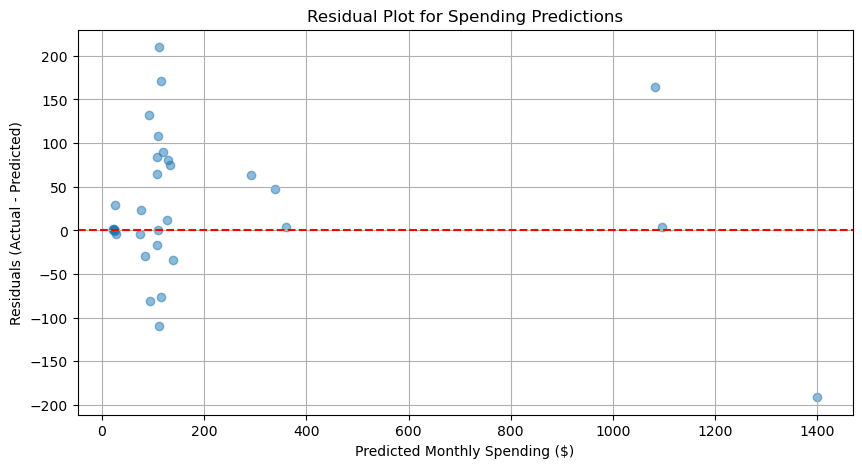

In [16]:
# Plotting residuals
residuals = y_test_actual - y_pred_actual
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_actual, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Monthly Spending ($)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for Spending Predictions')
plt.grid(True)
plt.show()